# <h1 style="font-family: Trebuchet MS; padding: 12px; font-size: 25px; color: #2D2926; text-align: center; line-height: 0.75;background-color: #41dcf7"><b>ICR - Identifying Age-Related Conditions: Classification problem</b><br></h1>

### Problem Statement:

The competition data comprises over fifty anonymized health characteristics linked to three age-related conditions. Your goal is to predict whether a subject has or has not been diagnosed with one of these conditions -- a binary classification problem.

### Data Dictionary:

- **Id**: Unique identifier for each observation;
- **AB-GL**: Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical;
- **Class A binary target**: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.

### Links:

[Competition Link](https://www.kaggle.com/competitions/icr-identify-age-related-conditions)



# <center><div style="font-family: Trebuchet MS; background-color: #41dcf7; color: #2D2926; padding: 12px; line-height: 1;">Data Preprocessing/Information</div></center>

### Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, make_scorer, roc_auc_score, average_precision_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.inspection import permutation_importance
import optuna

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgbm

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install featexp
from featexp import get_univariate_plots, get_trend_stats

### Data Reading:

In [3]:
# Reading all DataFrames
df_train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
df_test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
df_subm = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
df_greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

In [4]:
#Cheking test values
df_test.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Cheking extra train info
df_greeks.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [6]:
#Cheking train values
df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [7]:
#Label encoding columns
df_train.EJ = df_train.EJ.astype('category').cat.codes
df_greeks.Alpha = df_greeks.Alpha.astype('category').cat.codes
df_greeks.Beta = df_greeks.Beta.astype('category').cat.codes
df_greeks.Gamma = df_greeks.Gamma.astype('category').cat.codes
df_greeks.Delta = df_greeks.Delta.astype('category').cat.codes

#Converting the date feature into days
df_greeks.loc[df_greeks.Epsilon == 'Unknown', 'Epsilon'] = np.nan
df_greeks.Epsilon = pd.to_datetime(df_greeks.Epsilon)
df_greeks['Epsilon'] = (df_greeks.Epsilon - df_greeks.Epsilon.min()).dt.days

#Removing spaces from column names
df_train.columns = df_train.columns.str.replace(' ', '')
df_test.columns = df_test.columns.str.replace(' ', '')

#Merging datas to analysing
df_train_greeks = df_train.merge(df_greeks, on='Id')

#Adding the time column to train/test data
df_train['Time_days'] = df_greeks['Epsilon']
df_test['Time_days'] = df_greeks['Epsilon'].max() + 1

In [8]:
# N° of samples and N° features
print(f'N° Samples:  {df_train.shape[0]}')
print(f'N° features: {df_train.shape[1]}')

N° Samples:  617
N° features: 59


# <center><div style="font-family: Trebuchet MS; background-color: #41dcf7; color: #2D2926; padding: 12px; line-height: 1;">Exploratory Data Analysis</div></center>

### Checking Data Class:

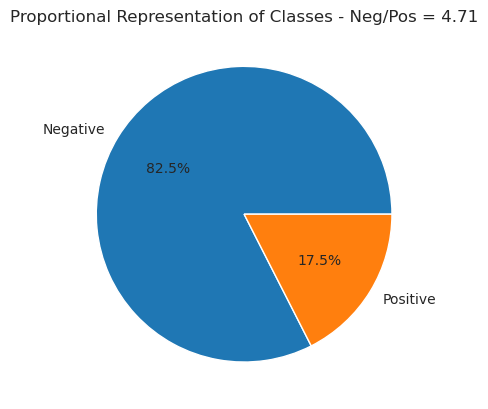

In [9]:
# Checking if is there an imbalanced class
df_imb = np.round(df_train['Class'].value_counts(normalize=True)*100, 2)
# Negative Values/Positive Values
imb_weight =  np.round(df_imb[0]/df_imb[1], 2)
#Ploting the imbalanced dataset
plt.pie(df_imb, labels = ['Negative','Positive'], autopct='%.1f%%')
plt.title(f'Proportional Representation of Classes - Neg/Pos = {imb_weight}')
plt.show()

82% of the data doesn't have any diseases, and 18% have at least 1 disease. Therefore, it could be said that the data is imbalanced.

### Data Train Statistics:

In [10]:
#Checking description
df_train_describe = np.round(df_train.describe(include='all').T, 2).drop(['unique', 'top', 'freq'], axis=1)
df_train_describe.insert(0, "data_type", df_train.dtypes)
df_train_describe.insert(1, "#missing", df_train.isna().sum())
df_train_describe.insert(3, "#unique", df_train.nunique())
df_train_describe

,data_type,#missing,count,#unique,mean,std,min,25%,50%,75%,max
Id,object,0,617,617,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AB,float64,0,617.0,217,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,float64,0,617.0,599,3502.013221,2300.322717,192.59328,2197.34548,3120.31896,4361.63739,28688.18766
AH,float64,0,617.0,227,118.624513,127.83895,85.200147,85.200147,85.200147,113.73954,1910.123198
AM,float64,0,617.0,605,38.968552,69.728226,3.177522,12.270314,20.53311,39.139886,630.51823
AR,float64,0,617.0,130,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,float64,0,617.0,427,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.27088
AY,float64,0,617.0,148,0.06032,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,float64,0,617.0,484,10.566447,4.350645,3.396778,8.12958,10.46132,12.969516,38.971568
BC,float64,0,617.0,259,8.053012,65.166943,1.2299,1.2299,1.2299,5.081244,1463.693448


- EJ and Id are the only categorical features. Id is not important for the ML model.
- There are 56 features (AB-GL) to feed the model and 1 target feature (Class).
- Almost all features are of the float data type.

### Missing Values:

<Axes: ylabel='% of NaN'>

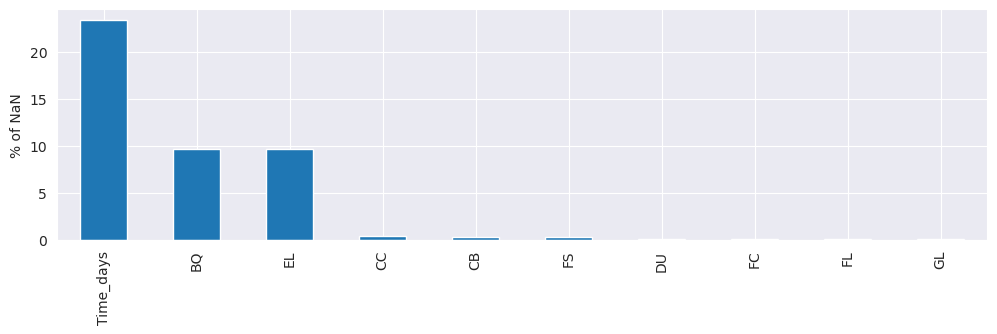

In [11]:
#Getting the columns with NaNs in descing order
sort_miss_cols = df_train.loc[:, (df_train.isna().sum() > 0)].isna().sum().sort_values(ascending=False).index
#Ploting the results
(df_train[sort_miss_cols].isna().sum()/df_train.shape[0]*100).plot.bar(figsize=(12,3), ylabel='% of NaN')

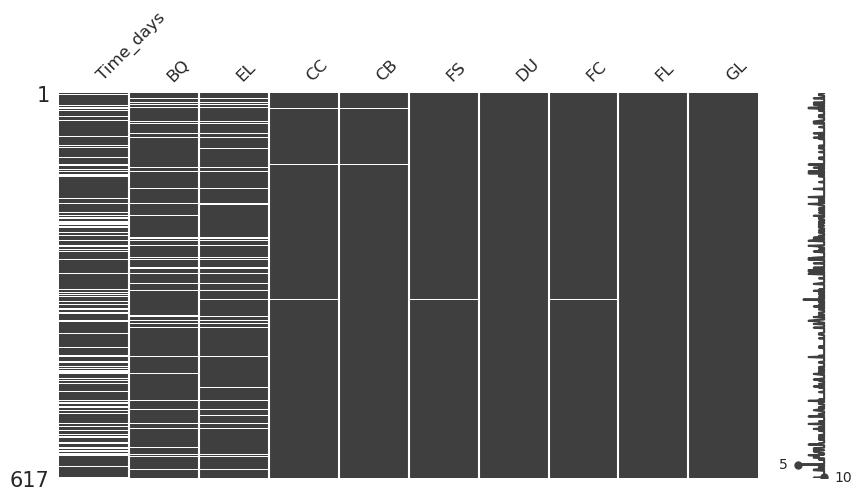

In [12]:
#Checking the NaNs by rows (looking for patterns)
missingno.matrix(df_train[sort_miss_cols], figsize=(10,5), fontsize=12);

It appears to have a relationship between NaNs in different columns, such as NaNs in BQ and EL, CC and CB, and CB, FS, and FC. This could provide insight on how to fill missing values.

### Cheking Outliers:

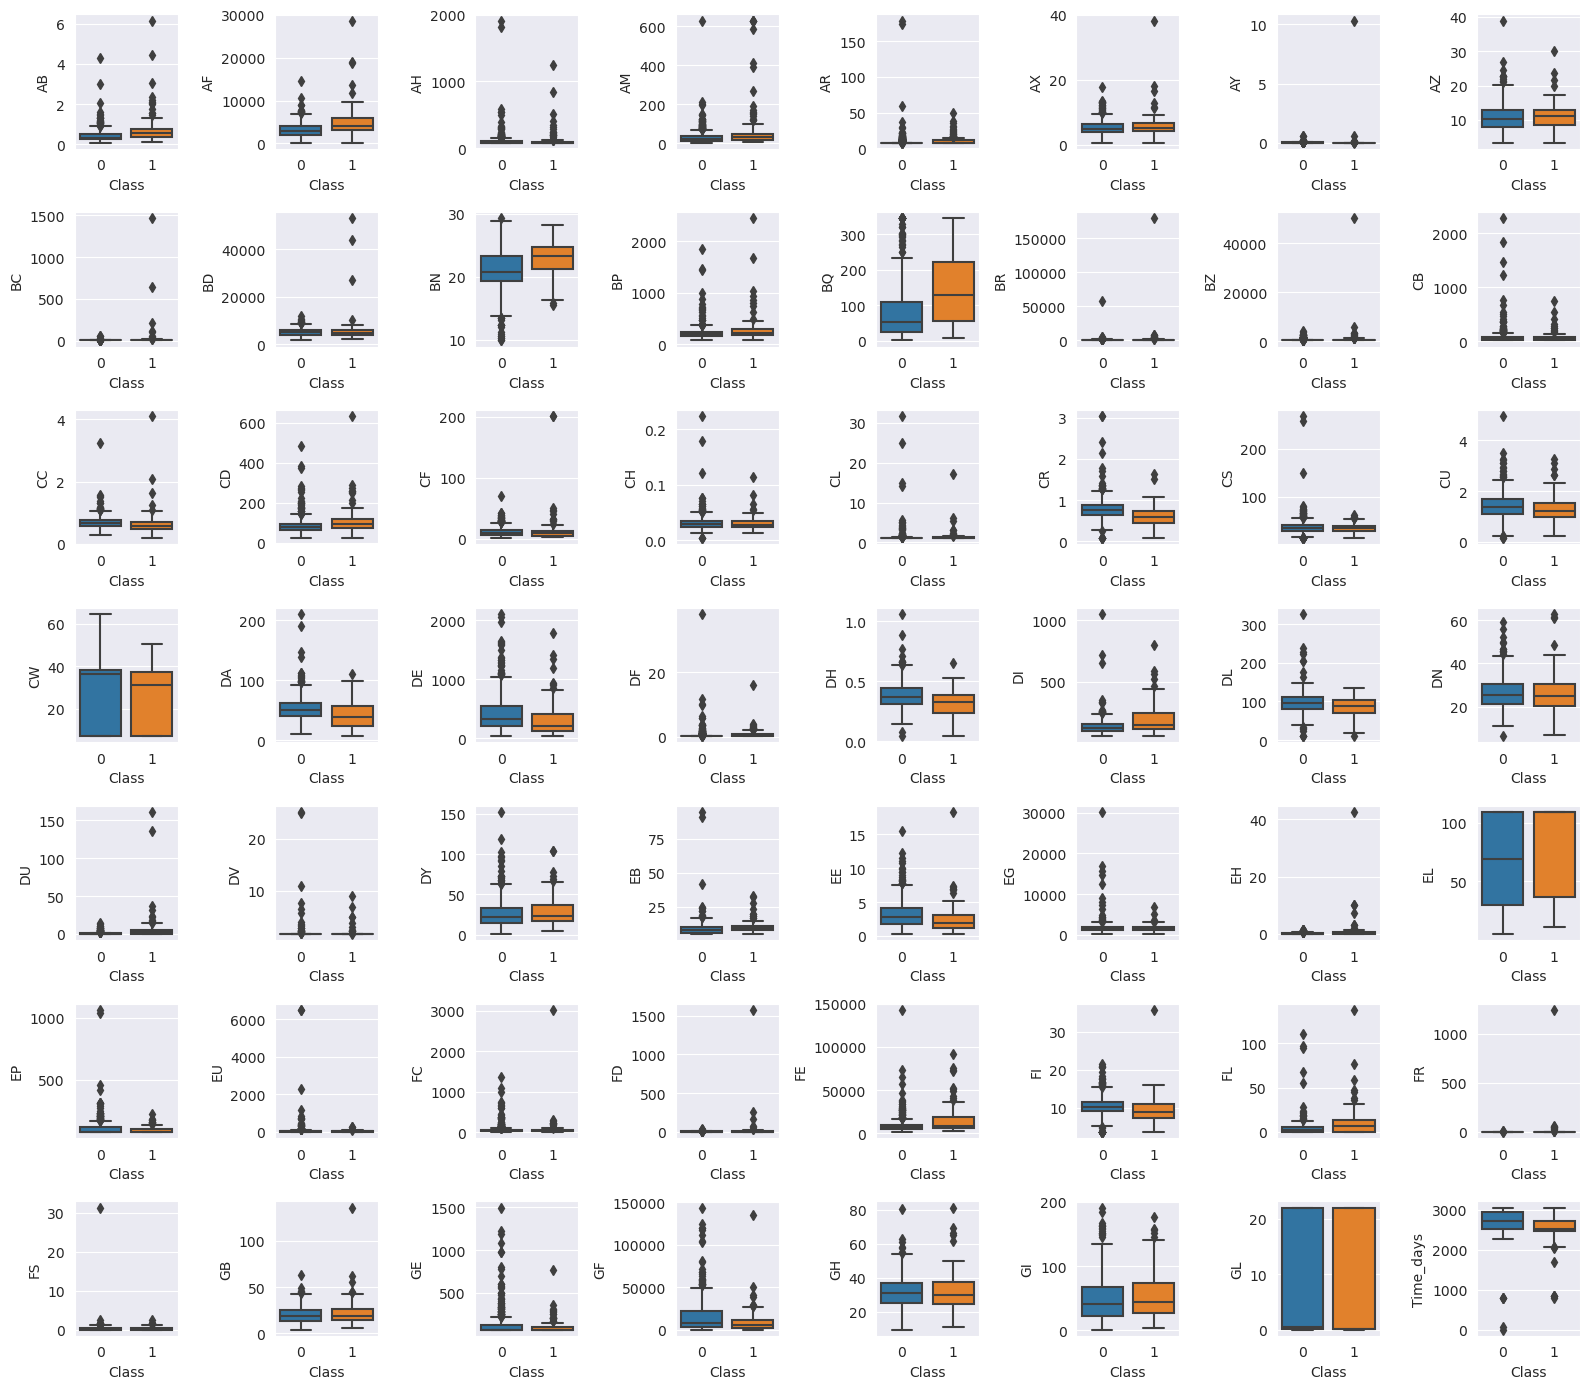

In [13]:
fig1, ax1 = plt.subplots(7,8, figsize=(16, 14))
cols_out = df_train.columns.drop(['Id', 'Class', 'EJ'])
for i, col in enumerate(cols_out):
    plt.subplot(7, 8, i+1)
    sns.boxplot(data=df_train, y=col, x='Class')
fig1.tight_layout()

Almost all features have a large number of outliers in both the 0 and 1 classes.

### PCA and TSNE - Cheking Clusters in Dataset: 

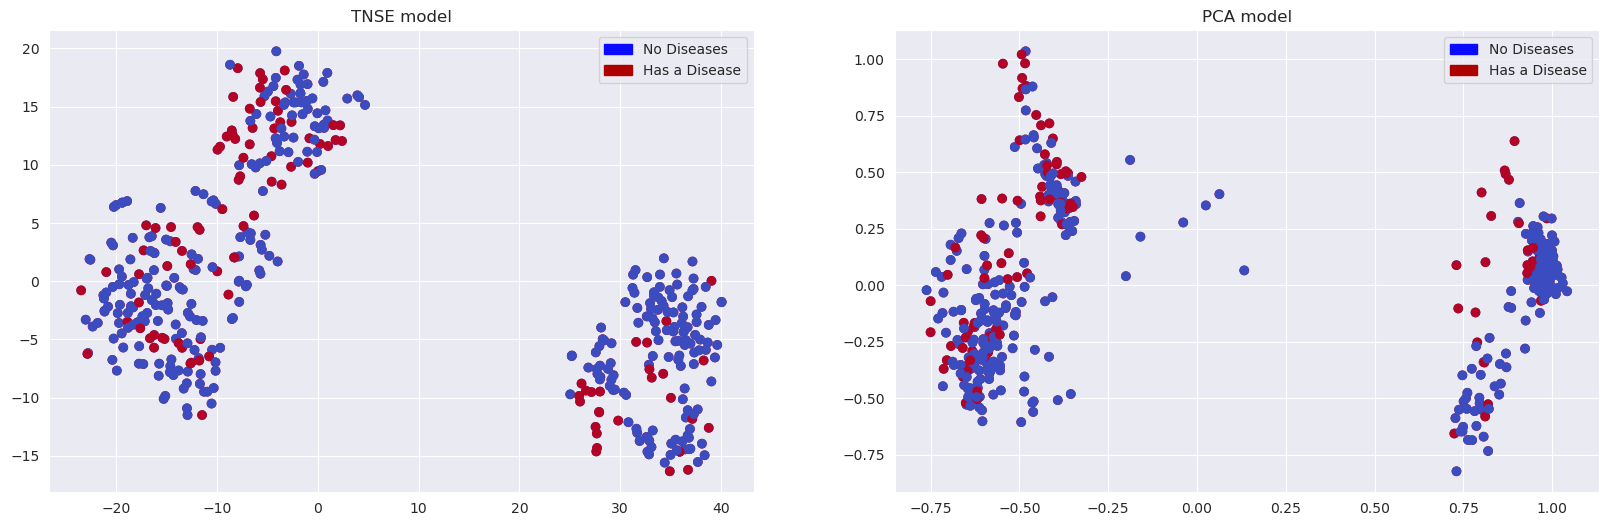

In [14]:
def fig_tnse_PCA(X_fig, y_fig):
    model_tnse = TSNE(n_components=2, random_state=30).fit_transform(X_fig)
    model_PCA = PCA(n_components=2, random_state=30).fit_transform(X_fig)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    blue_patch = mpatches.Patch(color='#0A0AFF', label='No Diseases')
    red_patch = mpatches.Patch(color='#AF0000', label='Has a Disease')

    plt.subplot(1,2,1)
    plt.title('TNSE model')
    plt.scatter(model_tnse[:,0], model_tnse[:,1], c=(y_fig == 0), cmap='coolwarm', label='No Diseases')
    plt.scatter(model_tnse[:,0], model_tnse[:,1], c=(y_fig == 1), cmap='coolwarm', label='Has a Disease')
    plt.legend(handles=[blue_patch, red_patch])

    plt.subplot(1,2,2)
    plt.title('PCA model')
    plt.scatter(model_PCA[:,0], model_PCA[:,1], c=(y_fig == 0), cmap='coolwarm', label='No Diseases')
    plt.scatter(model_PCA[:,0], model_PCA[:,1], c=(y_fig == 1), cmap='coolwarm', label='Has a Disease')
    plt.legend(handles=[blue_patch, red_patch])

#Ploting PCA and TNSE
df_PCA_TNSE = df_train.dropna()
min_max_norm = MinMaxScaler()
X_PCA_TSNE = min_max_norm.fit_transform(df_PCA_TNSE.drop(['Id', 'Class'], axis=1))
y_PCA_TSNE = df_PCA_TNSE.Class
fig_tnse_PCA(X_PCA_TSNE, y_PCA_TSNE)

### Cheking skewness:

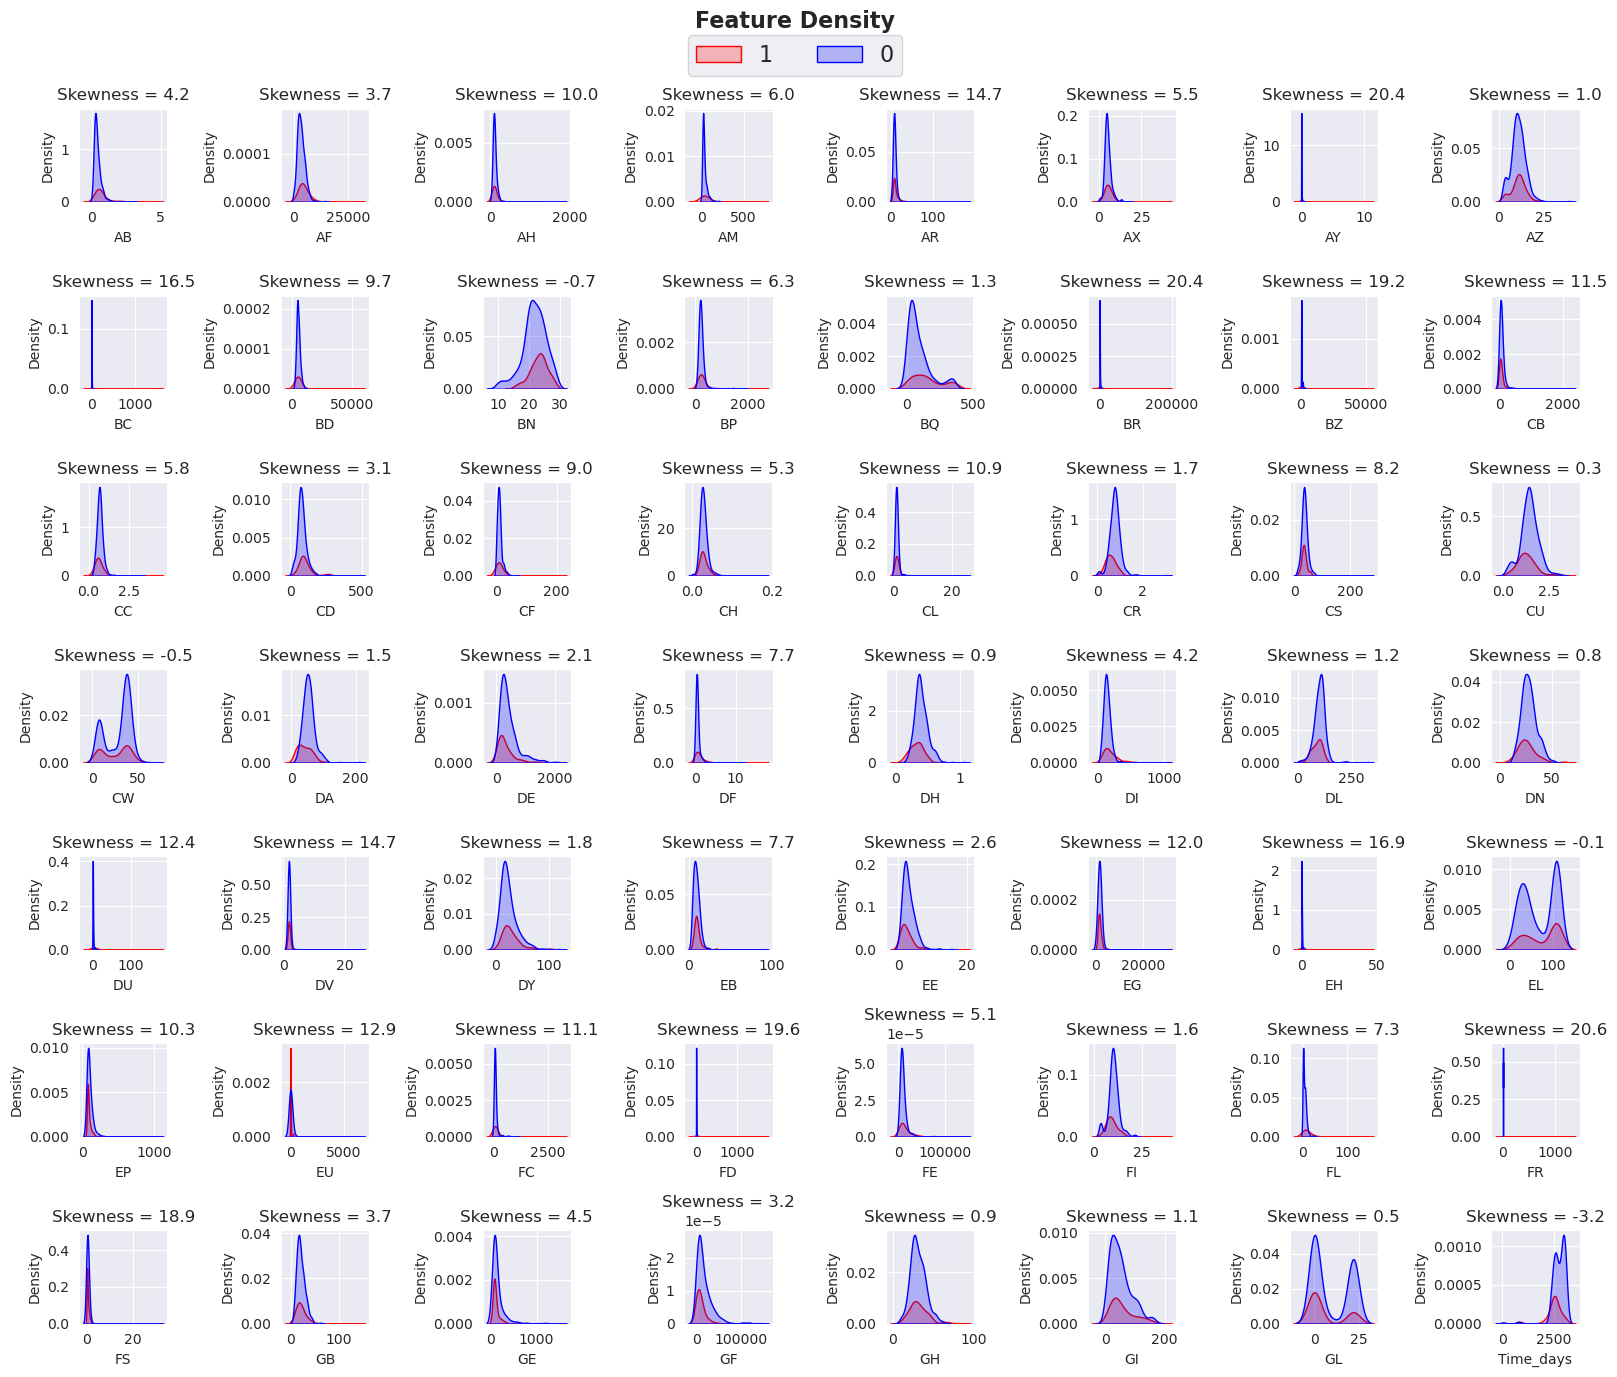

In [15]:
df_dist = df_train.dropna()
fig2, ax2 = plt.subplots(nrows=7, ncols=8, figsize=(16, 14))
fig2.suptitle('Feature Density\n\n', fontweight='bold', fontsize=16)


for i, col in enumerate(cols_out):
    plt.subplot(7,8,i+1)
    sns.kdeplot(data=df_dist, x=col, hue='Class', fill=True, palette=['blue', 'red'], legend=False) #, kde=False, fit=stats.norm
    plt.ylabel('Density')
    plt.title(f'Skewness = {df_dist[col].skew():.1f}')
fig2.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.97), fontsize=16, ncol=2)
fig2.tight_layout()

Many of the features distribution is right-skewed. So, $x^{1/2}$, $x^{1/3}$ and $log(x)$ are good ideas to deal with this data.

<Axes: >

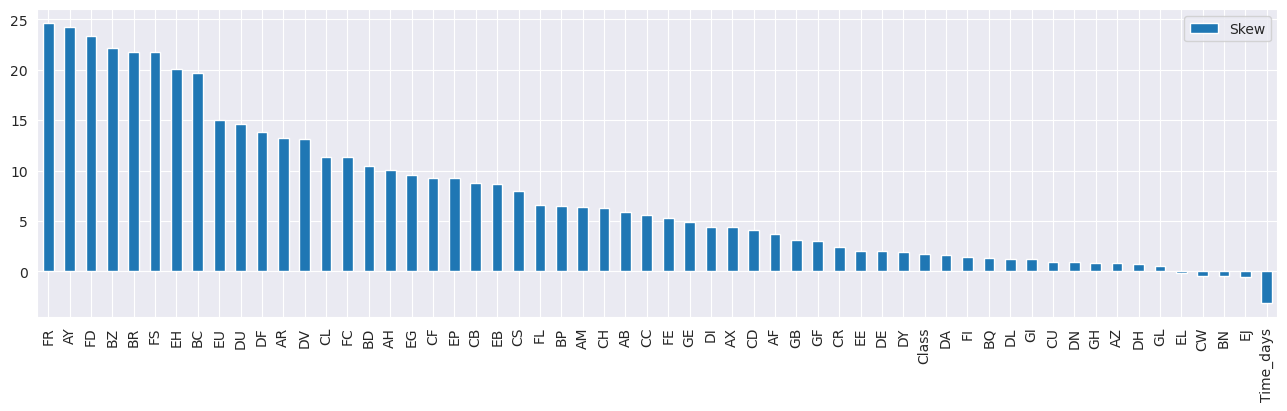

In [16]:
#Ploting the columns skewness in desceding order
df_train.skew().sort_values(ascending=False).to_frame(name='Skew').plot.bar(figsize=(16,4))

### Data Variance:

<Axes: >

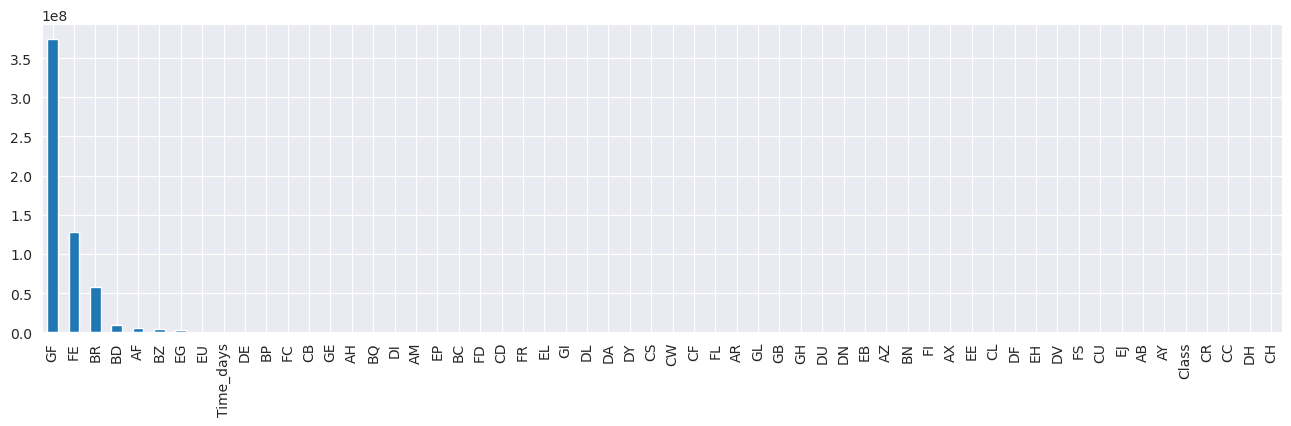

In [17]:
#Ploting data train variance
df_train.var().sort_values(ascending=False).plot.bar(figsize=(16,4))

The columns with more variance (GF, FE, BR, BD...) are the most likely candidates to be kept in feature selection. (They can capture distinct patterns)

### Feature Vs Target: 

                                             Plots for DU                                             


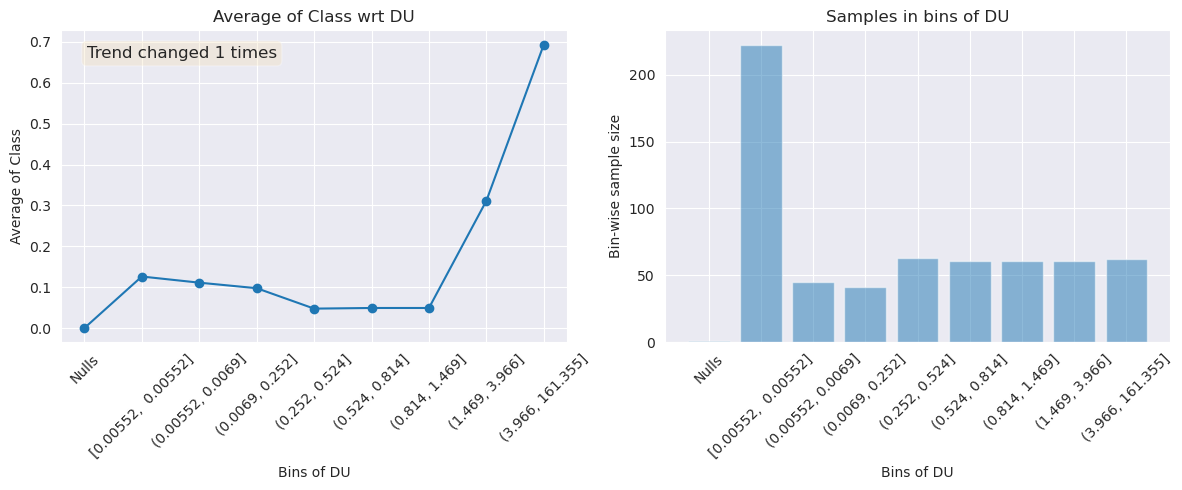

--------------------------------------------------------------------------------------------------------------


                                             Plots for BQ                                             


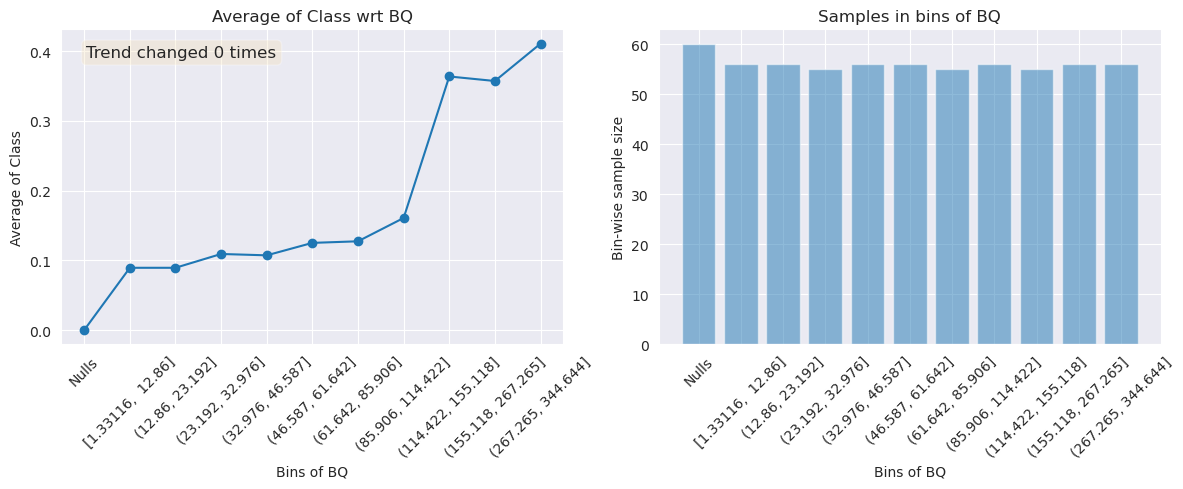

--------------------------------------------------------------------------------------------------------------


                                             Plots for BD                                             


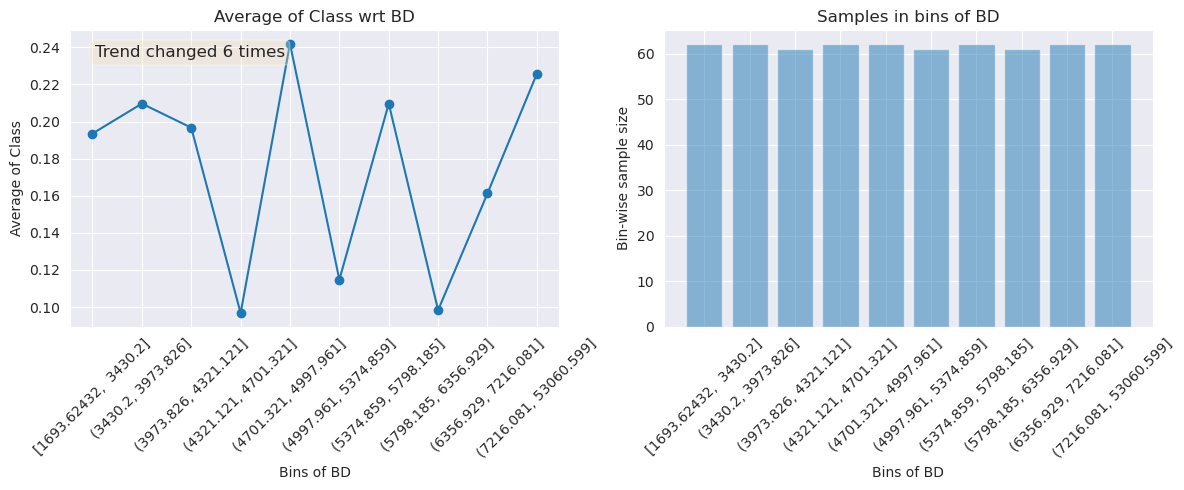

--------------------------------------------------------------------------------------------------------------


                                          Plots for Epsilon                                           


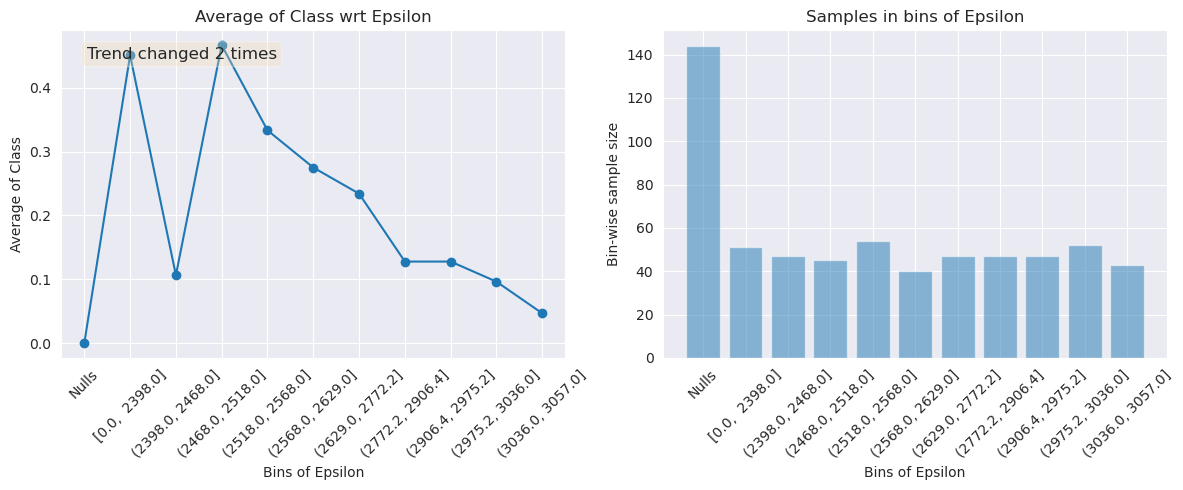

--------------------------------------------------------------------------------------------------------------




In [18]:
get_univariate_plots(data=df_train_greeks, target_col='Class', features_list=['DU', 'BQ', 'BD', 'Epsilon'])

#### Based on univariate plots, we can draw several conclusions:

- Bins with a high number of samples tend to have a low average due to data imbalance, and bins with low samples are not reliable.

- Most of the features exhibit numerous trend changes across the bins.

- Features that demonstrate a favorable behavior: AB, BC, BQ, CL, CR, DA, DF, DH, DI, DL, DU, EH, FD, FL, GL.

- Features that exhibit a moderate behavior: AF, AZ, BN, BP, BZ, CC, CD, DE, DY, EB, EE, EP, FE, FI, FR.

- Features that appear to be noisy: AM, AX, AY, BD, BR, CB, CF, CS, CW, DN, DV, EL, EU, FS, GF, GH, GI.

- Features with a significant single trend change: AH, AR, CU, FR, FS, GE.

- Features with limited variation: CH, EG, EJ, FC.

- The occurrence of the target class decreases with the time feature (Epsilon), indicating a temporal relationship between these features. Time series cross-validation could be a suitable option.

### Correlation Matrices:

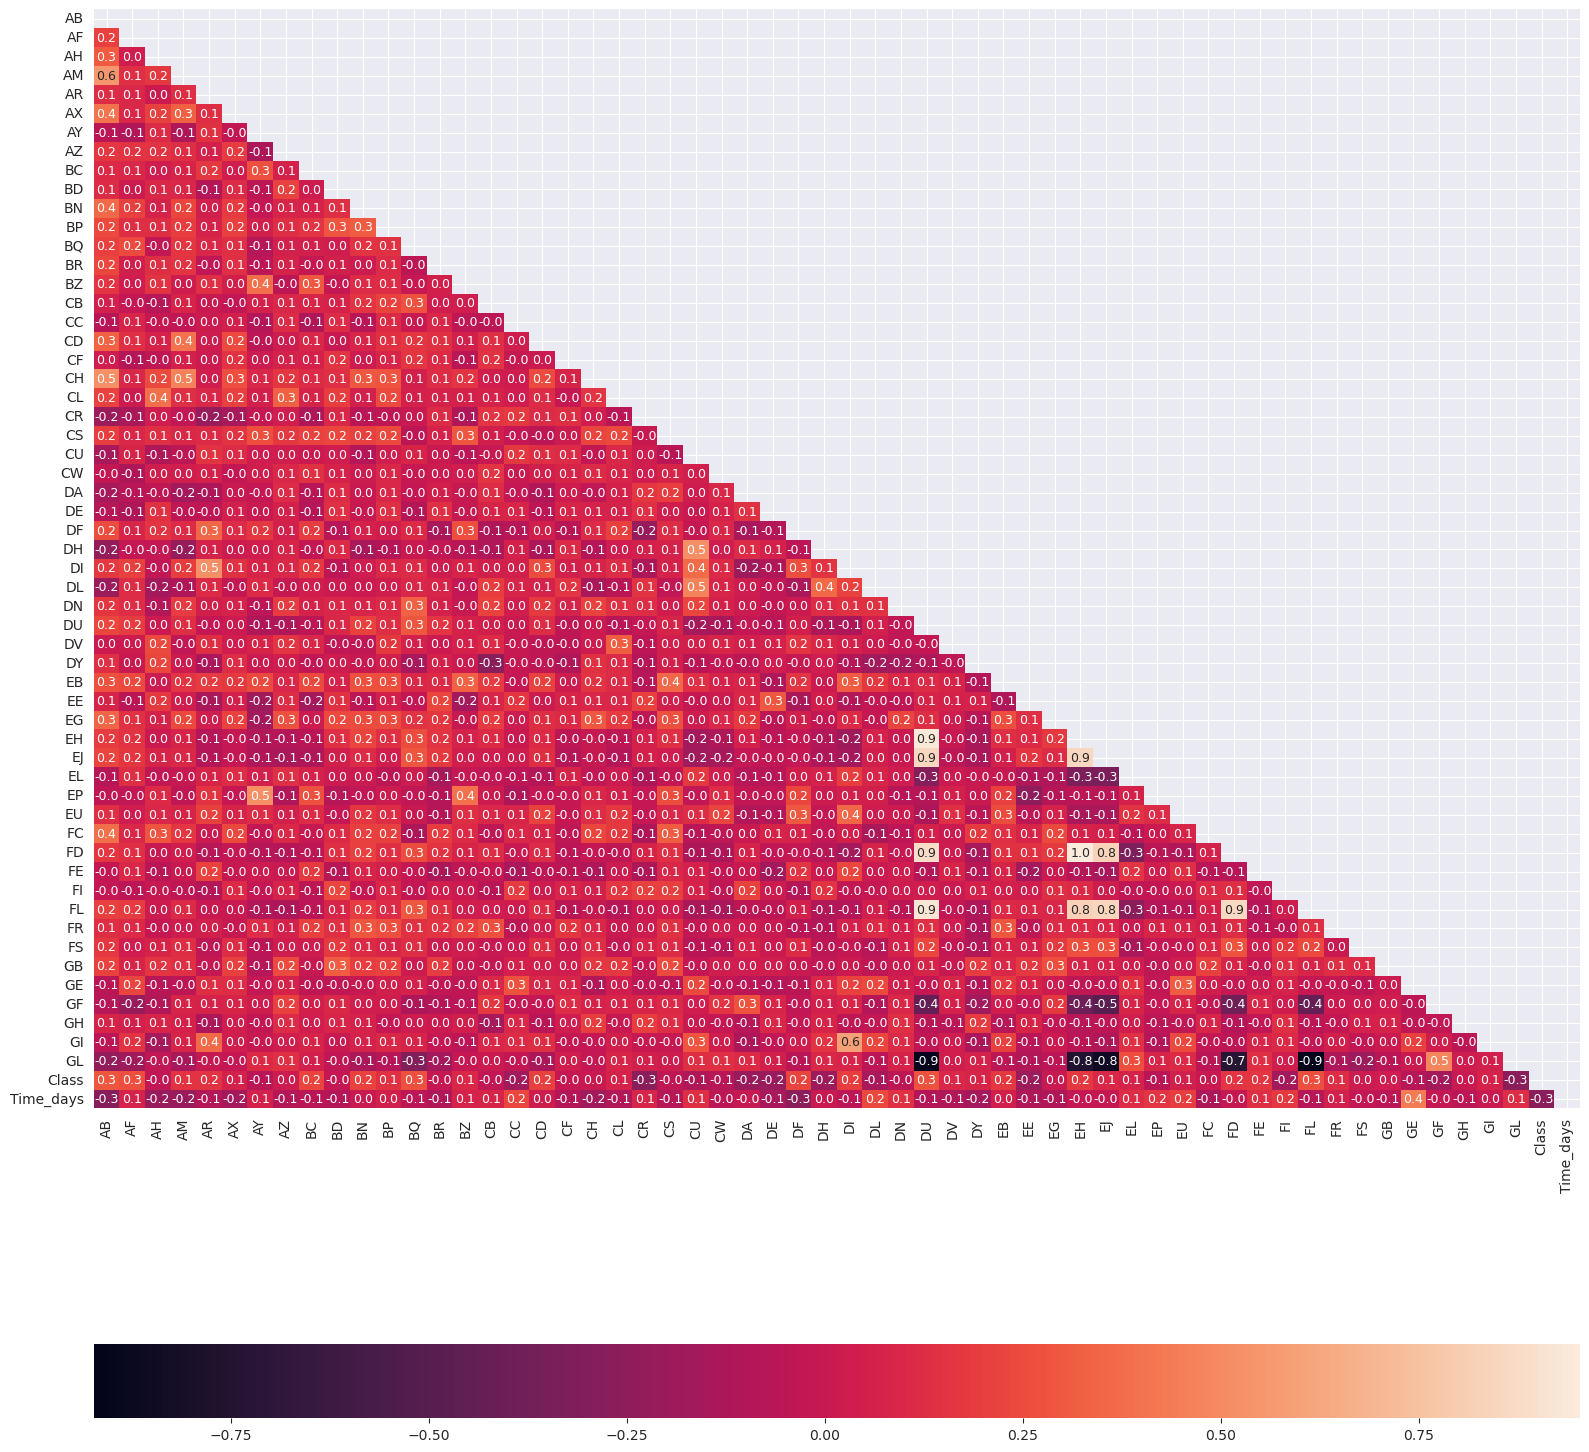

In [19]:
fig4 = plt.figure(figsize=(16, 16))
coors = df_train.corr(method='spearman')
mask = np.zeros_like(coors, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(coors, mask=mask, annot=True, annot_kws={"size": 9},
            cbar_kws={"orientation": "horizontal"}, fmt='.1f')
plt.yticks(rotation=0)
fig4.tight_layout()

There are some features correlated with each other, such as DU-EH, AM-AB, FL-GL. In some cases, it's beneficial to retain only one of them or use PCA to group them. In this notebook, all features were kept.

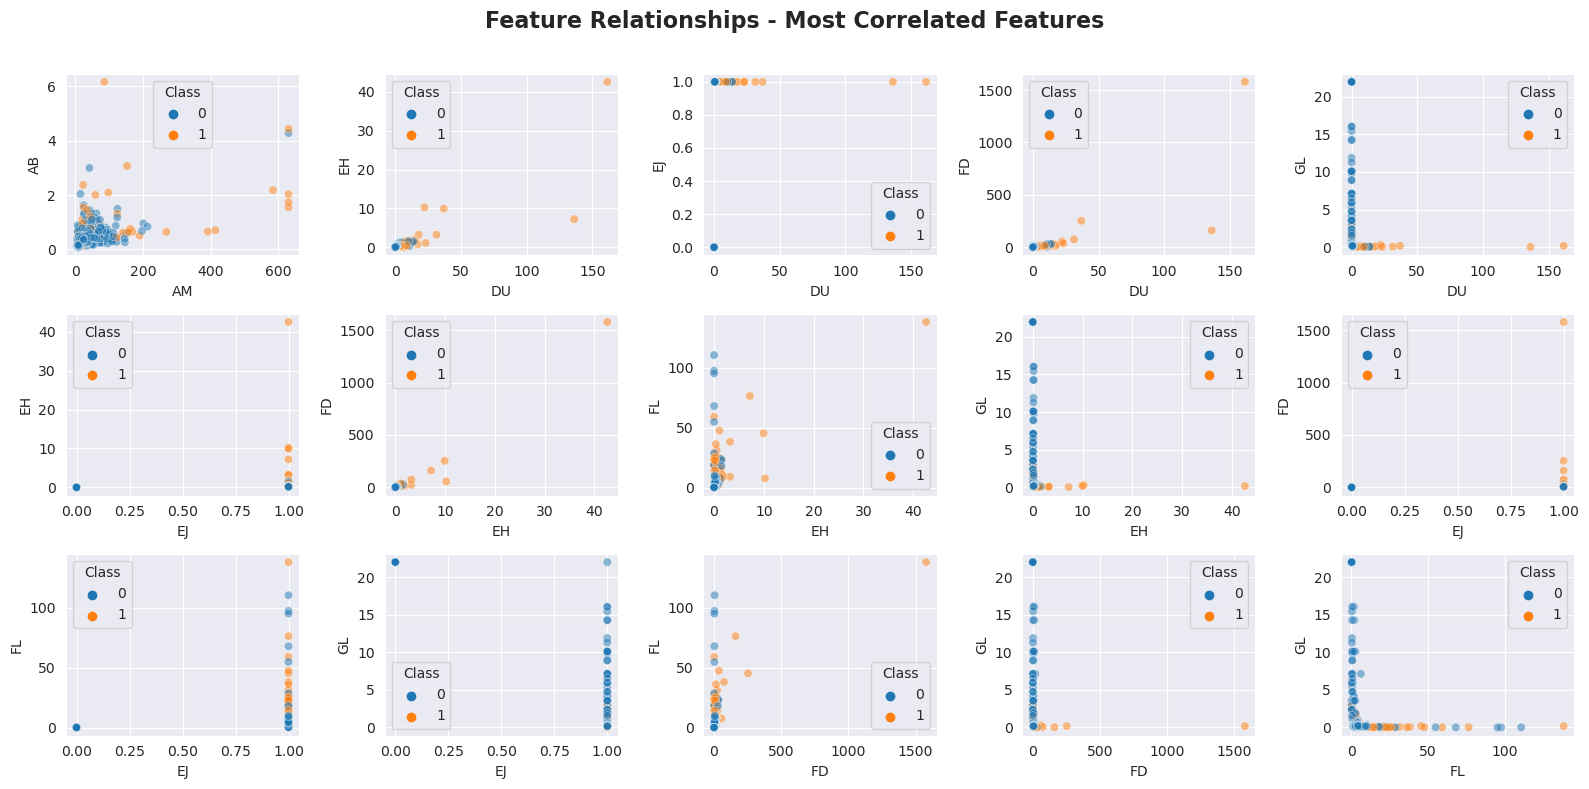

In [20]:
# Correlated features
list_corr_cols = [['AM', 'AB'], ['DU', 'EH'], ['DU', 'EJ'], ['DU', 'FD'], ['DU', 'GL'], ['EJ', 'EH'], ['EH', 'FD'], 
                  ['EH', 'FL'], ['EH', 'GL'], ['EJ', 'FD'], ['EJ', 'FL'], ['EJ', 'GL'], ['FD', 'FL'], ['FD', 'GL'], ['FL', 'GL']]
# Ploting the Correlated features
fig5, ax5 = plt.subplots(nrows=3, ncols=5, figsize=(16, 8))
fig5.suptitle('Feature Relationships - Most Correlated Features\n', fontweight='bold', fontsize=16)

for i, col in enumerate(list_corr_cols):
    plt.subplot(3, 5, i+1)
    sns.scatterplot(data=df_train, x=col[0], y=col[1], hue='Class', alpha=0.5)
fig5.tight_layout()

## Fill Missing Values:

In [21]:
# Creating a function to calculate the optimal number of neighbors for imputing missing values.
def KnnCv_nneighbors(k):
    #
    df_knn_cv = df_train.drop('Id', axis=1).dropna().reset_index(drop=True)
    # Using 5 kfolds
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    rmse = []
    # Imputing only in training set to avoid data leakage
    for (idx_train, idx_test) in kfold.split(df_knn_cv):
        knn_model = KNNImputer(n_neighbors=k, weights='distance')
        knn_model.fit(df_knn_cv.iloc[idx_train])
        
        df_transform = df_knn_cv.iloc[idx_test]
        df_transform['BQ'] = np.nan
        df_transform = pd.DataFrame(knn_model.transform(df_transform), columns=df_transform.columns)
        rmse.append(mean_squared_error(df_knn_cv.loc[idx_test, ['BQ']], df_transform['BQ'], squared=False))
    return round(np.mean(rmse), 2)

# Iterating over k=1 to 10 to observe their performance
rmses = pd.DataFrame([[k, KnnCv_nneighbors(k)] for k in range(1,11)], columns=['n_neighbors','Rmse']).T
rmses

,0,1,2,3,4,5,6,7,8,9
n_neighbors,1.00,2.00,3.0,4.00,5.00,6.00,7.00,8.0,9.00,10.00
Rmse,127.03,115.24,109.3,105.18,103.09,100.58,98.99,98.6,98.05,97.32


When performing cross-validation with a larger number of neighbors, the error is smaller.

In [22]:
#Filling Nans with KNNImputer
df_train_fillna = df_train.drop('Id', axis=1)
KNN_bestmodel = KNNImputer(n_neighbors=10, weights='distance')
df_train_WoNa = pd.DataFrame(KNN_bestmodel.fit_transform(df_train_fillna), columns=df_train_fillna.columns)
df_train_WoNa.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,Class,Time_days
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1.0,2497.000000
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0.0,2606.463015
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0.0,2791.772877
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0.0,2680.919592
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1.0,2869.000000


### Grouping Correlated Columns:

In [23]:
'''
# Inicializing the Min-Max normalizator
norm = MinMaxScaler()
# Name of corralated columns
corr_cols = ['EH', 'FD', 'FL', 'GL', 'DU'] #'EJ'] #'EJ'
# Creating a PCA model whitch get 95% of information of the data
model_pca = PCA(0.94, random_state=0)
# Copying the DataFrame
df_train_GCC = df_train_WoNa.copy()
# Normalizing and creating a new column with all 5 features
cols_pca = ['PCA_col1']# 'PCA_col2']
df_train_GCC[cols_pca] = model_pca.fit_transform(norm.fit_transform(df_train_GCC[corr_cols]))
# Normalizing PCA columns
#df_train_GCC[cols_pca] = norm.fit_transform(df_train_GCC[cols_pca])
#Droping the columns transformed
df_train_GCC = df_train_GCC.drop(corr_cols, axis=1)
# Printing how much the new feature explaing the 5 features
print(f'N° Cols: {len(corr_cols)} --> {model_pca.n_components_} (Explained_variance = {model_pca.explained_variance_ratio_.cumsum()[0]*100:.1f}%) // Cols --> {corr_cols}')
'''

"\n# Inicializing the Min-Max normalizator\nnorm = MinMaxScaler()\n# Name of corralated columns\ncorr_cols = ['EH', 'FD', 'FL', 'GL', 'DU'] #'EJ'] #'EJ'\n# Creating a PCA model whitch get 95% of information of the data\nmodel_pca = PCA(0.94, random_state=0)\n# Copying the DataFrame\ndf_train_GCC = df_train_WoNa.copy()\n# Normalizing and creating a new column with all 5 features\ncols_pca = ['PCA_col1']# 'PCA_col2']\ndf_train_GCC[cols_pca] = model_pca.fit_transform(norm.fit_transform(df_train_GCC[corr_cols]))\n# Normalizing PCA columns\n#df_train_GCC[cols_pca] = norm.fit_transform(df_train_GCC[cols_pca])\n#Droping the columns transformed\ndf_train_GCC = df_train_GCC.drop(corr_cols, axis=1)\n# Printing how much the new feature explaing the 5 features\nprint(f'N° Cols: {len(corr_cols)} --> {model_pca.n_components_} (Explained_variance = {model_pca.explained_variance_ratio_.cumsum()[0]*100:.1f}%) // Cols --> {corr_cols}')\n"

# <center><div style="font-family: Trebuchet MS; background-color: #41dcf7; color: #2D2926; padding: 12px; line-height: 1;">Feature Engineering</div></center>

## Transforming Skewed Data:

In [24]:
# Getting the columns to be transformed
colunas_TSD = df_train_WoNa.columns.drop(['Class', 'EJ']).to_list()
# Using the boxcox function to remove data skewness
df_train_WoSkns = pd.DataFrame(PowerTransformer(standardize=False).fit_transform(df_train_WoNa[colunas_TSD]), columns=colunas_TSD)
df_train_WoSkns = pd.concat([df_train_WoSkns, df_train_WoNa[['EJ', 'Class']]], axis=1)
# Scaling the data
df_train_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_train_WoSkns), columns= df_train_WoSkns.columns)
# Displaying the data
df_train_norm.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FS,GB,GE,GF,GH,GI,GL,Time_days,EJ,Class
0,0.271184,0.327538,0.000000,0.561604,0.0,0.000000,0.000000,0.262888,0.69259,0.384744,...,0.057691,0.269298,0.000000,0.340078,0.313690,0.685849,0.057657,0.513658,1.0,1.0
1,0.150003,0.148617,0.000000,0.664271,0.0,0.318342,0.000000,0.383684,0.00000,0.484795,...,0.598627,0.214045,0.000000,0.686922,0.435763,0.490898,1.000000,0.591588,0.0,0.0
2,0.580695,0.296820,0.000000,0.638640,0.0,0.481406,0.000000,0.362162,0.00000,0.461999,...,0.819855,0.612101,0.320753,0.576154,0.417783,0.511846,0.090517,0.741697,1.0,0.0
3,0.339324,0.368599,0.720442,0.786439,0.0,0.321970,0.000000,0.305042,0.00000,0.388550,...,0.354870,0.409089,0.217983,0.344648,0.590252,0.759611,0.073244,0.649071,1.0,0.0
4,0.498649,0.363862,0.000000,0.451345,0.0,0.338947,0.646319,0.000000,0.98564,0.498383,...,0.110765,0.374104,0.744634,0.510356,0.657259,0.518848,0.046858,0.811415,1.0,1.0


## Anomaly Detection:

In [25]:
# Create a multivariate distribution given our means and standard deviations
dist = multivariate_normal(mean=df_train_norm[colunas_TSD].mean().to_numpy(), cov=df_train_norm[colunas_TSD].cov().to_numpy())

# Calculate probability density values for our features for ALL values
proba1 = dist.pdf(df_train_norm[colunas_TSD].to_numpy())
proba2 = dist.pdf(df_test[colunas_TSD].to_numpy())

# Adding anomaly detection as a feature
df_train_norm['Anomaly'] = MinMaxScaler().fit_transform(proba1.reshape(-1,1))
df_test['Anomaly'] = MinMaxScaler().fit_transform(proba2.reshape(-1,1))
df_train_norm.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GB,GE,GF,GH,GI,GL,Time_days,EJ,Class,Anomaly
0,0.271184,0.327538,0.000000,0.561604,0.0,0.000000,0.000000,0.262888,0.69259,0.384744,...,0.269298,0.000000,0.340078,0.313690,0.685849,0.057657,0.513658,1.0,1.0,4.638528e-11
1,0.150003,0.148617,0.000000,0.664271,0.0,0.318342,0.000000,0.383684,0.00000,0.484795,...,0.214045,0.000000,0.686922,0.435763,0.490898,1.000000,0.591588,0.0,0.0,2.266608e-04
2,0.580695,0.296820,0.000000,0.638640,0.0,0.481406,0.000000,0.362162,0.00000,0.461999,...,0.612101,0.320753,0.576154,0.417783,0.511846,0.090517,0.741697,1.0,0.0,1.067664e-04
3,0.339324,0.368599,0.720442,0.786439,0.0,0.321970,0.000000,0.305042,0.00000,0.388550,...,0.409089,0.217983,0.344648,0.590252,0.759611,0.073244,0.649071,1.0,0.0,9.243706e-10
4,0.498649,0.363862,0.000000,0.451345,0.0,0.338947,0.646319,0.000000,0.98564,0.498383,...,0.374104,0.744634,0.510356,0.657259,0.518848,0.046858,0.811415,1.0,1.0,2.012694e-09


# <center><div style="font-family: Trebuchet MS; background-color: #41dcf7; color: #2D2926; padding: 12px; line-height: 1;">Feature Selection</div></center>

## Mutual information

<Axes: >

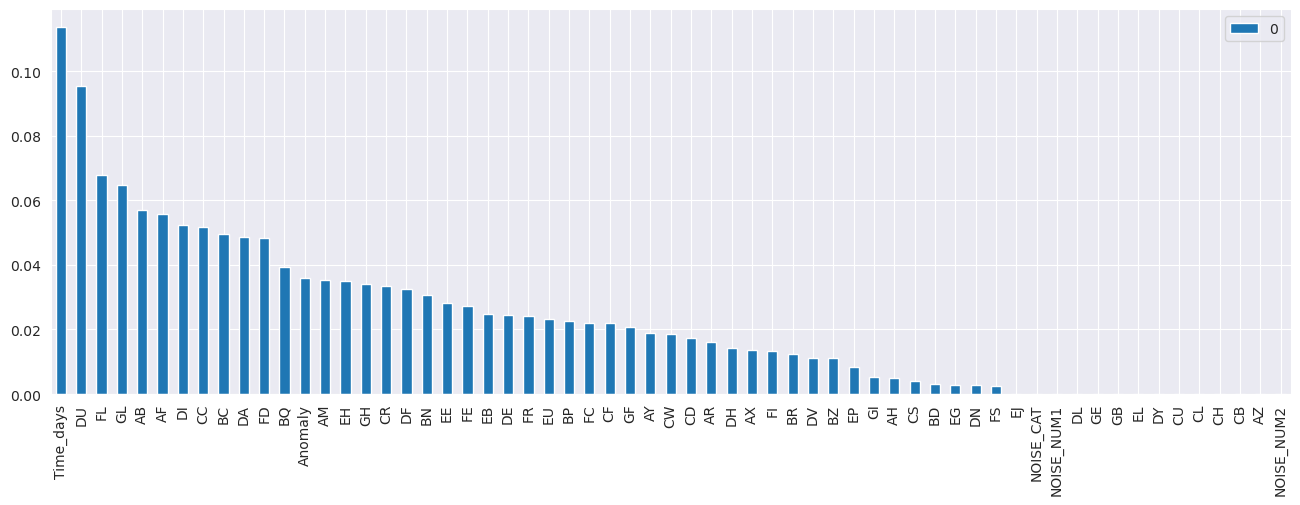

In [26]:
# Adding noise features to the dataset
df_fe = df_train_norm.copy()
df_fe['NOISE_NUM1'] = np.random.normal(size=len(df_fe))
df_fe['NOISE_CAT'] = np.random.randint(3, size=len(df_fe))
df_fe['NOISE_NUM2'] = np.random.randn(len(df_fe))

#Ploting mutual information of all features
MI = mutual_info_classif(df_fe.drop('Class', axis=1), df_fe['Class'], random_state=52)
pd.DataFrame(MI.reshape(1,-1), columns=df_fe.drop('Class', axis=1).columns).sort_values(by=0, axis=1,ascending=False).T.plot.bar(figsize=(16,5))

Through the feature's mutual information value, it is possible to assess its relationship with the class. An MI value of 0 could indicate that the feature does not introduce any information (EJ, DL, GE, GB, EL, DY, CU, CL, CH, CB, AZ).

## Trend correlation

Returning stats for all numeric features
Returning stats for all numeric features
Returning stats for all numeric features
Returning stats for all numeric features
Returning stats for all numeric features


<Axes: xlabel='Feature'>

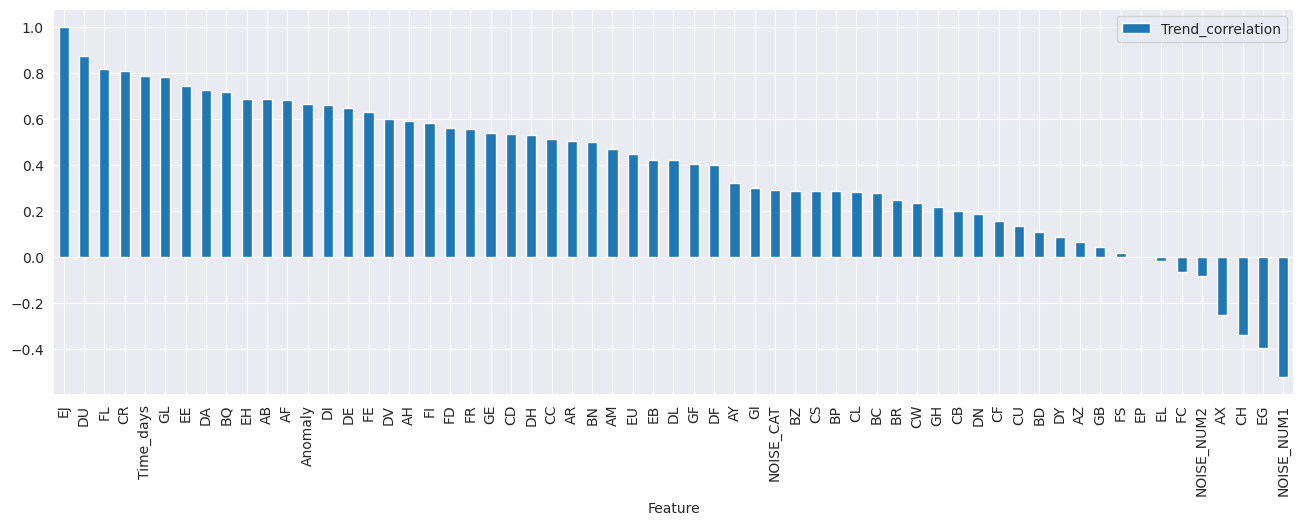

In [27]:
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
def cv_func(cv):
    trend_stats = []
    for train_index, test_index in cv.split(df_fe, df_greeks.Alpha):
        X_train_trend = df_fe.iloc[train_index]
        X_test_trend = df_fe.iloc[test_index]
        df_trend_corr = get_trend_stats(data=X_train_trend, target_col='Class', data_test=X_test_trend)[['Feature', 'Trend_correlation']]
        trend_stats.append(df_trend_corr)
    
    df_trend = pd.concat(trend_stats)
    df_trend_result = df_trend.groupby('Feature')['Trend_correlation'].mean().reset_index().sort_values(by='Trend_correlation', ascending=False)
    return df_trend_result

#Ploting the trend correlation beetwwwn train and test
df_trend = cv_func(cv_strat)
df_trend.plot.bar(x='Feature', figsize=(16, 5))

## Recursive Feature Elimination (RFE)

In [28]:
def RFE_SHAP(model_SFS): #, nfeaturesToKeep=1
    
    # Xtrain and ytrain
    X_train_SFS = df_train_norm.drop('Class', axis=1)
    y_train_SFS = df_train_norm.Class

    columns_SFS = X_train_SFS.columns
    #Initiating variables
    df_shap_results = pd.DataFrame(columns=X_train_SFS.columns)
    result_list, cols_list = [], []
    shap_min = 0
    #Loop until it finds SHAP>0.1
    while(shap_min<0.1): 
    #for i in range(nfeatures, nfeaturesToKeep-1, -1):
        X_SFS = X_train_SFS[columns_SFS]
        results_CV, _, __ = Nested_CV(model_SFS, X_SFS, y_train_SFS, df_ystrat)
        result_list.append(results_CV)
        #Shape values
        explainer_SFS = shap.TreeExplainer(model_SFS.fit(X_SFS, y_train_SFS))
        shap_values_SFS = explainer_SFS.shap_values(X_SFS)
        shap_values_SFS_abs_mean = np.abs(shap_values_SFS).mean(axis=0)
        #Selecting the feature to drop by the lowest shap value 
        index_min = np.argmin(shap_values_SFS_abs_mean)
        shap_min = shap_values_SFS_abs_mean[index_min]
        col_to_drop = columns_SFS[index_min]
        columns_SFS = columns_SFS.drop(col_to_drop)
        cols_list.append(columns_SFS)

        
    df_shap_results = pd.concat(result_list)
    return df_shap_results, cols_list[-2]
        
#df_shap_results, cols = RFE_SHAP(xgb.XGBClassifier())

In [29]:
# Dropping the columns with non-impact in the ML model
DropCols_ByTrendCorr = ['CB','DN','CF','CU','BD','DY','AZ','GB','FS','EP','EL','FC','AX','CH','EG']
ColsAfter_RFE = ['AB', 'AF', 'AM', 'BC', 'BP', 'BQ', 'CC', 'CD', 'CH', 'CR', 'CS', 'DA',
                 'DE', 'DL', 'DN', 'DU', 'DY', 'EB', 'EE', 'EG', 'EL', 'EP', 'EU', 'FE',
                 'FI', 'FL', 'FR', 'FS', 'GH', 'GL', 'Time_days', 'Anomaly', 'Class']
# Selecting the cols after feature selection
#df_train_FS = df_train_norm.drop(DropCols_ByTrendCorr, axis=1)
df_train_FS = df_train_norm[ColsAfter_RFE]
df_train_FS.head()

,AB,AF,AM,BC,BP,BQ,CC,CD,CH,CR,...,FE,FI,FL,FR,FS,GH,GL,Time_days,Anomaly,Class
0,0.271184,0.327538,0.561604,0.69259,0.485410,0.778560,0.421241,0.000000,0.508761,0.000000,...,0.587822,0.000000,0.558796,0.509872,0.057691,0.313690,0.057657,0.513658,4.638528e-11,1.0
1,0.150003,0.148617,0.664271,0.00000,0.434478,0.291082,0.359125,0.242762,0.626915,0.584626,...,0.516065,0.313691,0.000000,0.000000,0.598627,0.435763,1.000000,0.591588,2.266608e-04,0.0
2,0.580695,0.296820,0.638640,0.00000,0.345202,0.873375,0.368455,0.406935,0.683391,0.415134,...,0.568623,0.360339,0.569372,0.279240,0.819855,0.417783,0.090517,0.741697,1.067664e-04,0.0
3,0.339324,0.368599,0.786439,0.00000,0.597448,0.244639,0.521083,0.414725,0.594899,0.383706,...,0.632499,0.469297,0.524518,0.000000,0.354870,0.590252,0.073244,0.649071,9.243706e-10,0.0
4,0.498649,0.363862,0.451345,0.98564,0.692903,0.773543,0.400916,0.355013,0.541499,0.411699,...,0.713011,0.430679,0.580092,0.984249,0.110765,0.657259,0.046858,0.811415,2.012694e-09,1.0


# <center><div style="font-family: Trebuchet MS; background-color: #41dcf7; color: #2D2926; padding: 12px; line-height: 1;">Model Selection</div></center>

## Spliting the datasets:

In [30]:
# All Features 
df_Xtrain = df_train_FS.drop('Class', axis=1)
# Target Feature
df_ytrain = df_train_FS.Class
# Stratified Feature
df_ystrat = df_greeks.Alpha

## Useful Functions:

In [31]:
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)
    
def test_scores(best_estimator, X_test, y_test):
    #Index name
    colname = f"Test Scores - {str(best_estimator).split('(')[0]}"
    
    # Predicting X_Test
    y_proba_scores = best_estimator.predict_proba(X_test)[:, 1]
    y_score = best_estimator.predict(X_test)
    
    # Evaluating Important Metrics
    accuracy = accuracy_score(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_proba_scores)
    average_precision = average_precision_score(y_test, y_proba_scores)
    balanced_accuracy = balanced_accuracy_score(y_test, y_score)
    precision =  precision_score(y_test, y_score)
    recall = recall_score(y_test, y_score)
    f1score = f1_score(y_test, y_score)
    balance_log_loss = balanced_log_loss(y_test, y_proba_scores)
    
    scores = pd.DataFrame({'accuracy': [accuracy], 'roc_auc': [roc_auc], 'average_precision': [average_precision], 
                           'balanced_accuracy': [balanced_accuracy],'precision': [precision], 
                           'recall': [recall], 'f1_score': [f1score], 'balance_log_loss': [balance_log_loss]},
                         index = [colname])
    scores = np.round(scores, 3)
    return scores

def Stratified_CV(classifier, X, y, y_stratify, n_splits=5):

    cv_inner = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    colname = f"Train/Valid Scores - {str(classifier).split('(')[0]}"
    results_train, results_val = [], []
    
    for train_index, test_index in cv_inner.split(X, y_stratify):
        classifier.fit(X.iloc[train_index], y.iloc[train_index])
        results_train.append(test_scores(classifier, X.iloc[train_index], y.iloc[train_index]))
        results_val.append(test_scores(classifier, X.iloc[test_index], y.iloc[test_index]))
    
    cols = ['accuracy','roc_auc', 'average_precision', 'balanced_accuracy', 'precision', 'recall', 'f1_score', 'balance_log_loss'] 
    df_train = pd.DataFrame(np.mean(results_train, axis=0), columns=cols, index=['Train'])    
    df_val = pd.DataFrame(np.mean(results_val, axis=0), columns=cols, index=['Valid'])
    df_combined = pd.concat([df_train, df_val]).T
    df_combined[colname] = df_combined.apply(lambda row: f"{row['Train']:.3f}/{row['Valid']:.3f}", axis=1)
    df_cv_score = df_combined[colname].to_frame().T
    return df_cv_score

def Nested_CV(classifier, X, y, y_stratify):
    outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=24)
    test_scores_list = []
    models_list = []
    tv_scores_list = []

    for train_idx, test_idx in outer_cv.split(X, y_stratify):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test, y_strat = y.iloc[train_idx], y.iloc[test_idx], y_stratify.iloc[train_idx] 
        
        scores = Stratified_CV(classifier, X_train, y_train, y_strat)
        tv_scores_list.append(scores)
        
        model_class = classifier.fit(X_train, y_train)
        test_score = test_scores(model_class, X_test, y_test)
        test_scores_list.append(test_score)
        models_list.append(model_class)
    
    
    df_tv_scores = pd.concat(tv_scores_list)
    df_tv_scores_mean = df_tv_scores.apply(lambda col: col.str.split('/'))
    df_tv_scores_mean = df_tv_scores_mean.apply(lambda col: np.mean(np.array(col.to_list(), dtype=np.float64), axis=0))
    
    df_test = pd.concat(test_scores_list)
    df_test_mean = np.round(df_test.groupby(df_test.index).mean(), 3)
    
    df_results = pd.concat([df_tv_scores_mean, df_test_mean])
    df_results.index = ['Train', 'Valid', 'Test']
    df_results = df_results.apply(lambda row: f"{row['Train']:.3f}/{row['Valid']:.3f}/{row['Test']:.3f}").to_frame().T
    df_results.index = [f'Train/Valid/Test Scores - {str(classifier).split("(")[0]}']
    return df_results, df_test, models_list

## Logistic Regression Model:

In [32]:
#Tunnig Logistic Regression
def optuna_lr(trial, X_train, y_train, y_strat):
    # Hyperparameters 
    params_lr = {"C" : trial.suggest_loguniform('C', 0.1, 10.0),
                  "tol" : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
                  "max_iter" : trial.suggest_int('max_iter', 100, 2500),
                  "solver": trial.suggest_categorical('solver', ['liblinear', 'newton-cg', 'lbfgs']),
                  "penalty": trial.suggest_categorical('penalty', ['l2']),
                  "class_weight": trial.suggest_categorical('class_weight', ['balanced', None])
                 }
    # Logistic regression estimator
    model_lr = LogisticRegression(**params_lr,  n_jobs=-1)

    # Geting the scores
    scores_lr = Stratified_CV(model_lr, X_train, y_train, y_strat)
    
    return np.float(scores_lr['balance_log_loss'].str.split('/')[-1][-1])

def Nested_CV_Optuna_lr(X, y, y_stratify, ntrials=150):
    outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=24)
    best_scores = []
    BestModels_and_SamplesIndex = []

    for train_idx, test_idx in outer_cv.split(X, y_stratify):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test, y_strat = y.iloc[train_idx], y.iloc[test_idx], y_stratify.iloc[train_idx] 
        
        study_lr = optuna.create_study(direction='minimize')
        study_lr.optimize(lambda trial: optuna_lr(trial, X_train, y_train, y_strat), n_trials=ntrials)

        best_params_lr = study_lr.best_params
        best_params_lr['n_jobs'] = -1
        best_params_lr['class_weight'] = 'balanced'
        
        best_classifier_lr = LogisticRegression(**best_params_lr).fit(X_train, y_train)
        best_score = test_scores(best_classifier_lr, X_test, y_test)
        best_scores.append(best_score)
        BestModels_and_SamplesIndex.append([best_classifier_lr, train_idx])
    df_result = pd.concat(best_scores)
    df_result_mean = np.round(df_result.groupby(df_result.index).mean(), 3)

    return df_result_mean, df_result, BestModels_and_SamplesIndex

In [33]:
#NCV_lr_mean, NCV_lr_results, NCV_lr_models = Nested_CV_Optuna_lr(df_Xtrain, df_ytrain, df_ystrat)
#NCV_lr_mean

### Nested CV Mean Scores:

In [34]:
#NCV_lr_mean

### Nested CV Scores:

In [35]:
#NCV_lr_results

### XGB Model:

In [36]:
#Tunnig XGB Model
def optuna_XGB(trial, X_train, y_train, y_strat):
    # Hyperparameters XGB 
    param_XGB = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 700),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'eval_metric':'logloss',
        'n_jobs':-1,
        'scale_pos_weight': imb_weight
    }
    # XGB estimator
    model_XGB = xgb.XGBClassifier(**param_XGB)

    # Geting the scores
    scores_XGB = Stratified_CV(model_XGB, X_train, y_train, y_strat)
    
    return np.float(scores_XGB['balance_log_loss'].str.split('/')[-1][-1])

def Nested_CV_Optuna_XGB(X, y, y_stratify, ntrials=150):
    outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=24)
    best_scores = []
    best_models = []

    for train_idx, test_idx in outer_cv.split(X, y_stratify):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test, y_strat = y.iloc[train_idx], y.iloc[test_idx], y_stratify.iloc[train_idx] 
        
        study_XGB = optuna.create_study(direction='minimize')
        study_XGB.optimize(lambda trial: optuna_XGB(trial, X_train, y_train, y_strat), n_trials=ntrials)

        best_params_XGB = study_XGB.best_params
        best_params_XGB['eval_metric'] = 'logloss'
        best_params_XGB['n_jobs'] = -1
        best_params_XGB['scale_pos_weight'] = imb_weight
        
        best_classifier_XGB = xgb.XGBClassifier(**best_params_XGB).fit(X_train, y_train)
        best_score = test_scores(best_classifier_XGB, X_test, y_test)
        best_scores.append(best_score)
        best_models.append(best_classifier_XGB)
    df_result = pd.concat(best_scores)
    df_result_mean = np.round(df_result.groupby(df_result.index).mean(), 3)

    return df_result_mean, df_result, best_models

In [37]:
#NCV_xgb_mean, NCV_xgb_results, NCV_xgb_models = Nested_CV_Optuna_XGB(df_Xtrain, df_ytrain, df_ystrat)
#NCV_xgb_mean

### Nested CV Mean Scores:

In [38]:
#NCV_xgb_mean

### Nested CV Scores:

In [39]:
#NCV_xgb_results

In [40]:
#Nested CV results - best XGB model
columns = ['accuracy', 'roc_auc', 'average_precision', 'balanced_accuracy', 'precision', 'recall', 'f1_score', 'balance_log_loss']
results_NCV = [0.94, 0.976, 0.91, 0.901, 0.82, 0.842, 0.83, 0.142]
index_name = 'Test Scores - XGBClassifier'
df_NCV = pd.DataFrame(results_NCV, index=columns, columns=[index_name]).T
df_NCV

,accuracy,roc_auc,average_precision,balanced_accuracy,precision,recall,f1_score,balance_log_loss
Test Scores - XGBClassifier,0.94,0.976,0.91,0.901,0.82,0.842,0.83,0.142


# <center><div style="font-family: Trebuchet MS; background-color: #41dcf7; color: #2D2926; padding: 12px; line-height: 1;">Machine Learning Model</div></center>

In [41]:
#XGB paramns
XGBModel_params = [
{'objective': 'binary:logistic','colsample_bytree': 0.3909668758277791,'eval_metric': 'logloss','gamma': 0.00013222296079514473,'learning_rate': 0.03191503291051318,
 'max_depth': 3,'min_child_weight': 4,'n_estimators': 445,'n_jobs': -1,'reg_alpha': 0.4726795122932336,'reg_lambda': 0.00012273868404805927,'scale_pos_weight': 4.71,
 'subsample': 0.9069030678363166,},
{'objective': 'binary:logistic','colsample_bytree': 0.8487196546378447,'eval_metric': 'logloss','gamma': 4.7418937539789095e-05,'learning_rate': 0.0790814312892002,
 'max_depth': 5,'min_child_weight': 3,'n_estimators': 224,'n_jobs': -1,'reg_alpha': 3.759309262151679e-05,'reg_lambda': 7.264468926628166e-05,'scale_pos_weight': 4.71,
 'subsample': 0.40685882145653185},
{'objective': 'binary:logistic','colsample_bytree': 0.3369214593648313,'eval_metric': 'logloss','gamma': 0.00038609211701563345,'learning_rate': 0.018803972164176872,
 'max_depth': 3,'min_child_weight': 5,'n_estimators': 547,'n_jobs': -1,'reg_alpha': 0.006386271101025525,'reg_lambda': 1.2087488112118428e-06,'scale_pos_weight': 4.71,
 'subsample': 0.5139855841663151},
{'objective': 'binary:logistic','colsample_bytree': 0.6319249441363146,'eval_metric': 'logloss','gamma': 1.0146125097436612e-05,'learning_rate': 0.04995234248020104,
 'max_depth': 12,'min_child_weight': 5,'n_estimators': 280,'n_jobs': -1,'reg_alpha': 0.08655935859462295,'reg_lambda': 8.070235024643146e-06,'scale_pos_weight': 4.71,
 'subsample': 0.48059425614940415}
]

In [42]:
# Creating a class to ensemble XBG models 
class XGBEnsemble:
    def __init__(self, trained_models):
        self.models = trained_models
    
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.round(np.mean(predictions, axis=0))
    
    def predict_proba(self, X):
        predictions = np.array([model.predict_proba(X) for model in self.models])
        return np.mean(predictions, axis=0)

#Training the best models with its best hyperparameter and sample
models_xgb = [
    xgb.XGBClassifier(**XGBModel_params[i]).fit(df_Xtrain.iloc[train_index], df_ytrain.iloc[train_index])
    for i, (train_index, _) in enumerate(StratifiedKFold(n_splits=4, shuffle=True, random_state=24).split(df_Xtrain, df_ystrat))
]

# Create an instance of the ensemble class
xgb_ensemble = XGBEnsemble(models_xgb)

## Submission:

In [43]:
df_test_subm = df_test.loc[:, df_Xtrain.columns]
df_subm.iloc[:,1:] = xgb_ensemble.predict_proba(df_test_subm)
df_subm.to_csv('submission.csv', index=False)